# Modeling: Predict book rating per user

This recommender system aims to predict the rating and preferences of users on books. In this case, the approach used to suggest books is **Collaborative Filtering**. 

The assumption of this approach is that people who have liked an item in the past will also like the same in future. This approach builds a model based on the past behaviour of users. The user behaviour may include previously watched videos, purchased items, given ratings on items. In this way, the model finds an association between the users and the items. The model is then used to predict the item or a rating for the item in which the user may be interested. *Singular value decomposition* is widely used as a collaborative filtering approach in recommender systems, which is also the chosen model in this concrete case. 


The **Singular Value Decomposition (SVD)** is a method from linear algebra that has been generally used as a dimensionality reduction technique in machine learning. SVD is a matrix factorisation technique, which reduces the number of features of a dataset by reducing the space dimension from N-dimension to K-dimension (where K<N). In the context of the recommender system, the SVD uses a matrix structure where each row represents a user, and each column represents a book. The elements of this matrix are the ratings that are given to books by users. The factorisation of this matrix is done by the singular value decomposition, which is a method of decomposing a matrix into three other matrices. In this case, the aim is to reveal latent factors in the rating matrix by minimizing the Root Mean Squared Error (RMSE). More about the matrices can be found on [Wikipedia](https://en.wikipedia.org/wiki/Singular_value_decomposition). Furthermore, the SVD model works with *latent features*, which are 'hidden' features to distinguish them from observed features. Latent features are computed from observed features using matrix factorization. An example would be text document analysis. 'words' extracted from the documents are features. Examples of latent features in SVD matrices can be found [here](https://www.dataminingapps.com/2020/02/singular-value-decomposition-in-recommender-systems/)

##### Source: https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/

### Main Libraries Needed:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from typing import * # Library for Dictionary
from surprise import accuracy
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split

### Dataset

In [2]:
df = pd.read_csv('Prepared.csv', error_bad_lines=False, delimiter=',', encoding = 'ISO-8859-1') 
df.head(3)

,User-ID,ISBN,Book-Rating,AVG-Rating,Vote-Count,City,State,Country,Age-Range,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,2313,034545104X,5,6.285714,28,cincinnati,ohio,usa,20-24,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,8680,034545104X,5,6.285714,28,st. charles county,missouri,usa,0-9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
2,10314,034545104X,9,6.285714,28,beaverton,oregon,usa,40-49,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books


In [3]:
print("{:.0f} books are rated per user on average".format(df.groupby('User-ID')['ISBN'].nunique().mean()))

6 books are rated per user on average


Extract all users with more ratings than the average to have a good foundation for the model:

In [4]:
df_xtrct = df.loc[np.where(df.groupby('User-ID')['ISBN'].nunique() >= df.groupby('User-ID')['ISBN'].nunique().mean())]

In [5]:
print("{} rows will take place in future work with a total of {} unique books".format(df_xtrct.shape[0], df_xtrct['Book-Title'].nunique()))

10328 rows will take place in future work with a total of 2353 unique books


----------

### Data Preprocessing
Data preprocessing is the conversion of data into machine-readable form that can be interpreted, analysed and used by machine learning algorithms. 

In this section detection of outliers and anomalies usually takes place. However, in our case no such actions are needed due to the **user-based collaborative filtering** implemented. It is a technique used to predict the items that a user might like on the basis of ratings given to that item by the other users who have similar taste with that of the target user. Therefore, the prediction is based on finding similarities between users, not among features. Actually, there are no dependent variables at all as collaborative filtering approach is not the typical regression approach.


The steps undertaken to preprocess the data for modeling are as follows:

##### Step 1: Features adjustment
Keep the only 3 attributes necessary for the work of the algorithm: user id, book title & rating. It is important that the features are in this order, too.

In [6]:
df_xtrct = pd.DataFrame(df_xtrct[{'User-ID', 'Book-Title', 'Book-Rating'}])
df_xtrct = df_xtrct.rename(columns={"User-ID": "userId", "Book-Title": "title", "Book-Rating": "rating"})

In [7]:
# Adjust the position of the columns for "Dataset"

users = df_xtrct['userId']
df_xtrct.drop(labels=['userId'], axis=1, inplace = True)
df_xtrct.insert(0, 'userId', users)

titles = df_xtrct['title']
df_xtrct.drop(labels=['title'], axis=1, inplace = True)
df_xtrct.insert(1, 'title', titles)

df_xtrct

,userId,title,rating
31,11676,The Notebook,10
36,24878,The Notebook,7
58,157823,The Notebook,10
59,158295,The Notebook,8
60,167812,The Notebook,10
...,...,...,...
65336,128122,Final Target,10
65350,193898,Final Target,9
65383,69593,The Lottery Winner : Alvirah And Willy Stories,7
65387,83084,The Lottery Winner : Alvirah And Willy Stories,9


Adjust the data types of the 3 columns:

In [8]:
df_xtrct['userId'] = df_xtrct['userId'].astype('string')
df_xtrct['title'] = df_xtrct['title'].astype('string')
df_xtrct['rating'] = df_xtrct['rating'].astype('int32')

df_xtrct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10328 entries, 31 to 65389
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  10328 non-null  string
 1   title   10328 non-null  string
 2   rating  10328 non-null  int32 
dtypes: int32(1), string(2)
memory usage: 282.4 KB


The focus is now on the SVD algorithm chosen for the purpose of predicting book rating per user.

##### Step 2: Create a Reader
A reader tells our SVD what the lower and upper bound of our ratings is. In this case, the ratings are from 1 to 10.

In [9]:
reader = Reader(line_format='user item rating', rating_scale=(1, 10))

##### Step 3: Create a new Dataset instance with our dataframe and the reader
It is important to mention again that the dataframe needs to have 3 columns in this specific order: user_id, product_id, rating.

In [10]:
data = Dataset.load_from_df(df_xtrct, reader=reader)

##### Step 4: Split the data into train and testsets
25% of the data are kept for testing.

In [11]:
trainset, testset = train_test_split(data, test_size=.25, random_state=42)

----------

### Model training 
Train a new SVD model

In [12]:
model = SVD()
model.fit(trainset)

The SVD decomposes the main matrix into 3 and these matrices has latent features. This is how the books matrix looks like:

In [13]:
item_to_row_idx: Dict[Any, int] = model.trainset._raw2inner_id_items

# Unpacking a dict into a DataFrame for readibility
item_to_row_idx_df = pd.DataFrame(
    list(item_to_row_idx.items()),
    columns=['Book name', 'model.qi row idx'],
)
item_to_row_idx_df.head(5)

,Book name,model.qi row idx
0,Pay It Forward,0
1,The Street Lawyer,1
2,Life of Pi,2
3,Intimate Partners: Patterns in Love and Marriage,3
4,The Wonderful Story of Henry Sugar and Six More,4


How to identify a particular book:

In [14]:
book_row_idx : int = item_to_row_idx['Hearts In Atlantis']
model.qi[book_row_idx]

array([ 1.12985531e-01, -1.76395099e-01, -8.39288644e-02, -8.70399833e-02,
       -3.52111736e-02,  4.22965507e-02, -1.26508933e-02, -4.83173128e-02,
        1.28716463e-01, -3.31191708e-02, -1.45614783e-01, -7.20504742e-02,
       -2.06994939e-02,  1.88656329e-01,  2.96496571e-02,  1.54800054e-01,
        1.17974247e-01, -1.01245168e-01, -6.40245016e-02,  3.92439842e-02,
        1.60752775e-01,  2.45715654e-01, -1.17835642e-01,  4.92659962e-02,
       -1.56643963e-01, -8.49097442e-02, -6.83964645e-02, -8.42265238e-02,
       -1.17910189e-02, -7.53033170e-02,  2.97766459e-01,  7.95646535e-02,
        2.35084342e-01,  4.93404881e-05, -1.08624254e-01,  4.06023778e-02,
       -7.56797744e-02,  1.23004888e-01, -3.81610936e-02,  2.30739998e-03,
        2.23196326e-01,  1.18084572e-01,  4.94449301e-02, -8.60081813e-02,
       -9.70847962e-02,  8.75482267e-02, -9.29108525e-02,  2.76862984e-02,
       -6.29803280e-02,  1.57865068e-01, -7.85221927e-03,  6.47372496e-02,
       -1.59373174e-02,  

Loaded are all its latent features. 

In [15]:
print(f"Every book has {model.qi[book_row_idx].shape[0]} features")

Every book has 100 features


----------

### Predicting

#### Predict a score between any combination of user and a book

Load the dataset *UniqueBooks.csv* where each row represents a unique book without repetitions. Therefore, it contains less rows in comparison with the main dataset (*df*), which will speed up the process of identifying the searched book based on the input title.

In [16]:
unq_books = pd.read_csv('UniqueBooks.csv', error_bad_lines=False, delimiter=',', encoding = 'ISO-8859-1') 
unq_books

,Book-Title,Year-Of-Publication,Book-Author,AVG-Rating,Publisher,Vote-Count,ISBN
0,Flesh Tones: A Novel,2002,M. J. Rose,6.285714,Ballantine Books,28,034545104X
1,Rites of Passage,2001,Judith Rae,4.800000,Heinle,5,0571117880
2,The Notebook,1996,Nicholas Sparks,7.897611,Warner Books,293,0446605239
3,Help!: Level 1,1999,Philip Prowse,3.000000,Cambridge University Press,1,052165615X
4,The Amsterdam Connection : Level 4 (Cambridge ...,2001,Sue Leather,6.000000,Cambridge University Press,1,0521795028
...,...,...,...,...,...,...,...
118716,A MARRIAGE MADE AT WOODSTOCK,1995,Cathie Pelletier,7.000000,Washington Square Press,1,0671516949
118717,The WEIGHT OF WINTER,1993,Cathie Pelletier,9.000000,Washington Square Press,1,067179387X
118718,Time Out Chicago (Time Out Chicago),2000,Time Out,9.000000,Penguin Books,1,0140290788
118719,The Zen of Proposal Writing: An Expert's Stres...,2002,Kitta Reeds,7.000000,Three Rivers Press (CA),1,0609806491


The *Fuzzy Wuzzy* package has functions that allow fuzzy or inexact string inputs to match with the closest value from various options. In this case, the class *process* will be imported and its method *extractOne* will be used for identifying the title searched. To speed up the method execution, installation of python-Levenshtein is suggested. This is an extension module that contains functions for fast computation, but its usage will not be implemented at this phase. If the recommender system is deployed, the implementation of this module is advisable.

In [17]:
from fuzzywuzzy import process
bookName = process.extractOne("Aatlantis", unq_books['Book-Title'])[0]
print(bookName)

C:\Users\HOME\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Atlantis.


For example, let us imagine that a user of the system searches for a book and inputs *Aatlantis* in the search bar with a typo. The result after applying the fuzzy wuzzy method is a book with title *Atlantis.*, which is probably what the user has been searching for. It is the closest result to the input, as the word *Atlantis* is included in various book titles, as follows:

In [18]:
unq_books[unq_books['Book-Title'].str.contains("Atlantis")].head()

,Book-Title,Year-Of-Publication,Book-Author,AVG-Rating,Publisher,Vote-Count,ISBN
1415,Atlantis Gate (Atlantis),2002,Greg Donegan,7.00000,Berkley Publishing Group,2,0425185729
4041,Hearts In Atlantis,2000,Stephen King,7.60000,Pocket,75,0671024248
6281,Atlantis Found,2001,Clive Cussler,7.22449,Berkley Publishing Group,49,0425177173
8055,Atlantis.,1999,Stephen King,8.00000,"Heyne GmbH &amp; Co. KG, Verlag",1,3453159926
8690,Hearts In Atlantis : New Fiction,1999,Stephen King,7.74000,Scribner,50,0684853515


After identifying the book title, the id of the user will be randomly selected:

In [19]:
userId = pd.Series([np.random.choice(df['User-ID'],1)[0]])[0]
print("The generated user is with id: {}".format(userId))

The generated user is with id: 162713


Now, it is time to predict what rating this user would give to the book *Atlantis.* using the SVD model:

In [20]:
user_rating_prediction = model.predict(userId, bookName)
user_rating_prediction

Prediction(uid=162713, iid='Atlantis.', r_ui=None, est=7.741285824941905, details={'was_impossible': False})

In [21]:
print("The model predicted a rating of {:,.2f}".format(user_rating_prediction[3]))

The model predicted a rating of 7.74


Try out a few other predictions of books that have already been rated by a user. For instance, get a few rating inputs of the following user:

In [22]:
user_ratings = df[df['User-ID'] == 6251].head(5)
user_ratings

,User-ID,ISBN,Book-Rating,AVG-Rating,Vote-Count,City,State,Country,Age-Range,Book-Title,Book-Author,Year-Of-Publication,Publisher
762,6251,043935806X,9,9.047393,211,wahiawa,hawaii,usa,30-34,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic
1187,6251,0440498058,10,8.876543,81,wahiawa,hawaii,usa,30-34,A Wrinkle In Time,MADELEINE L'ENGLE,1998,Yearling
1415,6251,0786817070,8,7.719626,107,wahiawa,hawaii,usa,30-34,"Artemis Fowl (Artemis Fowl, Book 1)",Eoin Colfer,2002,Miramax Kids
2681,6251,1566911605,10,10.000000,1,wahiawa,hawaii,usa,30-34,Moon Handbooks: Hawaii,J. D. Bisignani,1999,Moon Travel Handbooks
5172,6251,0380977788,8,8.164948,97,wahiawa,hawaii,usa,30-34,Coraline,Neil Gaiman,2003,HarperTrophy


Use the model to predict the rating of the first book:

In [23]:
user = "6251"
book = "Harry Potter and the Order of the Phoenix (Book 5)"
user_rating_prediction = model.predict(user, book)
print("The model predicted a rating of {:,.2f}".format(user_rating_prediction[3]))

The model predicted a rating of 9.59


The predicted rating is just like the actual. If this user so highly rated this book, he/she would most certainly rate high other Harry Potter books, too. This is a good way to observe the behavior of the trained model.

Check whether the user has read all Harry Potter books:

In [24]:
user_ratings[user_ratings['Book-Title'].str.contains("Harry Potter")].head()

,User-ID,ISBN,Book-Rating,AVG-Rating,Vote-Count,City,State,Country,Age-Range,Book-Title,Book-Author,Year-Of-Publication,Publisher
762,6251,043935806X,9,9.047393,211,wahiawa,hawaii,usa,30-34,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic


Fortunately, the user has not. Now, this is a good foundation for trying out the model:

In [25]:
user = "6251"
book = "Harry Potter and the Prisoner of Azkaban (Book 3)"
user_rating_prediction = model.predict(user, book)
print("The model predicted a rating of {:,.2f} for '{}'".format(user_rating_prediction[3], book))

The model predicted a rating of 9.34 for 'Harry Potter and the Prisoner of Azkaban (Book 3)'


In [26]:
user = "6251"
book = "Harry Potter and the Goblet of Fire (Book 4)"
user_rating_prediction = model.predict(user, book)
print("The model predicted a rating of {:,.2f} for '{}'".format(user_rating_prediction[3], book))

The model predicted a rating of 9.25 for 'Harry Potter and the Goblet of Fire (Book 4)'


In [27]:
user = "6251"
book = "Harry Potter and the Chamber of Secrets (Book 2)"
user_rating_prediction = model.predict(user, book)
print("The model predicted a rating of {:,.2f} for '{}'".format(user_rating_prediction[3], book))

The model predicted a rating of 9.22 for 'Harry Potter and the Chamber of Secrets (Book 2)'


The results are highly satisfying. This individual rating prediction feature of the system is valuable and might be a game changer after integration.

#### Suggest books to read next 

Furthermore, this feature may be used to generate personal recommendations regarding which books to read next. This can be done by going through all book titles and estimating rating prediction for a given user. 

The first step to achieve this is to exclude those books that have already been read and rated by the user specified. Then, use the model to generate predictions for each not rated book. Finally, extract the top 10 books with highest rating. 


In this case, stick to the user with id *6251*:

In [28]:
def generate_recommended_books_for_user(user_id: int) -> pd.DataFrame:
    
    # Get all rows with rating inputs from the user
    rated_books = df[df['User-ID'] == user_id]

    # Iterate through all books and remove the books present in the rated_books extract
    notrated_books = unq_books
    counter = 0
    for book in notrated_books['Book-Title']:
            for rated_book in rated_books['Book-Title']:
                if(book.lower().strip().replace('s/+',"") == rated_book.lower().strip().replace('s/+',"")):
                    counter += 1
                    rated_books = rated_books[rated_books['Book-Title'].replace('s/+',"") != rated_book.replace('s/+',"")]
                    notrated_books = notrated_books[notrated_books['Book-Title'].replace('s/+',"") != book.replace('s/+',"")]
                    break
                
    
    # Estimate ratings for each not rated book
    results = []
    for book_title in notrated_books['Book-Title']:
        
        # For each book, calculate score prediction 
        prediction = model.predict(user_id, book_title)
        results.append((prediction.est, book_title))
       
    return pd.DataFrame(results, columns=['Estimated Prediction', 'Book Title'])


# Call the method to generate some recommendations for a user
recommendations = generate_recommended_books_for_user(6251)

In [29]:
from IPython.display import display, HTML, Markdown

import warnings
warnings.filterwarnings('ignore')


def display_best_recommendations(recommendations: pd.DataFrame):
    """Return a DataFrame containing recommendations for the user, and the
    associated score
    """
    recommendations.sort_values('Estimated Prediction', ascending=False, inplace=True)

    top_recommendations = recommendations.iloc[:10]
    top_recommendations.columns = ['Prediction (sorted by best)', 'Book Title']

    display(HTML("<h1>Recommendations your user will love</h1>"))
    display(top_recommendations)

In [30]:
display_best_recommendations(recommendations)

,Prediction (sorted by best),Book Title
348,8.840318,Harry Potter and the Sorcerer's Stone (Harry P...
980,8.778157,A Prayer for Owen Meany
363,8.727342,To Kill a Mockingbird
1849,8.665713,The Bean Trees
2612,8.650743,The Pact: A Love Story
293,8.614883,Harry Potter and the Chamber of Secrets (Book 2)
540,8.612156,Fahrenheit 451
492,8.588465,Restaurant At the End of the Universe
233,8.559134,The Da Vinci Code
1105,8.530528,The Fountainhead


----------

### Model Evaluation

#### MSE & RMSE Evaluation Metrics
The MAE and the RMSE can be used together to diagnose the variation in the errors in a set of forecasts. The RMSE will always be larger or equal to the MAE; the greater difference between them, the greater the variance in the individual errors in the sample. Both the MAE and RMSE can range from 0 to ∞. Lower values are better.
##### Sources: www.eumetrain.org/data/4/451/english/msg/ver_cont_var/uos3/uos3_ko1.htm & www.i2tutorials.com/differences-between-mse-and-rmse/

The Mean Square Error (MSE) measure for accuracy square is calculated in the following way:

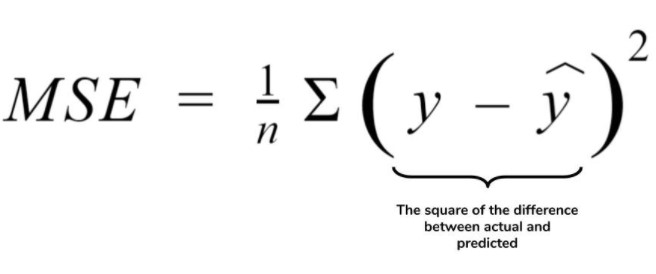

In [31]:
from IPython.display import Image
Image("MSE.jpg")

The MSE formula represents the difference between the original and predicted values which are extracted by squaring the average difference over the data set. It is a measure of how close a fitted line is to actual data points. The lesser the Mean Squared Error, the closer the fit is to the data set.

RMSE (Root Mean Squared Error) is the error rate by the square root of MSE. Since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE is most useful when large errors are particularly undesirable. The RMSE is calculated with the following formula:

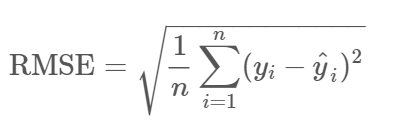

In [32]:
Image("RMSE_Formula.png")

Focus is going to be put on RMSE for this modeling as the aimed result is to predict a rating as close to the actual as possible. Therefore, large differences between actual and predicted values are undesired and the RMSE results would allow their detection more accurately compared to MSE results.

To begin with, let us calculate the RMSE of the test set after having trained the SVD model with the training data.

In [33]:
# Optionally, validate the RMSE (root-mean-square error) to ensure model training was effective
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 1.7131


The RMSE result is larger than 1. Common variations are between 0 and 1. The reason behind the unusual RMSE result might be connected to some data transormations in the model. For example, Singular Value Decomposition (SVD), which is the model used, applies vectorization of the variables along with matrix factorization. In addition, linear transformations might also take place. When such modifications are present, a solution to overcome such barriers is normalizing the RMSE. In brief, apply the NRMSE (Normalized RMSE). One way to do this is to normalize by the mean, in other words divide the RMSE score by the average rating as response variable.

Calculate the average rating:

In [34]:
values = 0
for x in testset:
    values += x[2]
values

size = len(testset)
size

avg = values / size
avg

7.731216111541441

In [35]:
norm_rmse = rmse / avg
norm_rmse

0.22158374896364136

The results are highly satisfying. The closer the score to 0, the better, which means the smaller the errors. 

#### Assess the model performance using cross validation. 


As there is never enough data to train your model, removing a part of it for testing and validation poses a problem of underfitting. By reducing the training data, we risk losing important patterns/trends in data set, which in turn increases error induced by bias. So, what we require is a method that provides ample data for training the model and also leaves ample data for validation.
##### Source: https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f

What the following method *cross_validate* does is that it divides the data into 5 subsets, which is a usually preferred splitting number. Then, the holdout method is repeated 5 times, such that each time, one of the subsets is used as the test set/validation set and the other 4 subsets are put together to form a training set. The error estimation is averaged over all 5 trials to get total effectiveness of our model. In this way, every data point gets to be in a validation set exactly once, and gets to be in a training set 4 times. This significantly reduces bias as most of the data is used for fitting, and also significantly reduces variance as most of the data is also being used in validation set. Interchanging the training and test sets also adds to the effectiveness of this method.


Finally, the results are as follows:

In [36]:
cross_validate(model, data, cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6896  1.7241  1.7012  1.7192  1.7187  1.7106  0.0130  
MAE (testset)     1.3228  1.3471  1.3333  1.3412  1.3623  1.3414  0.0133  
Fit time          0.59    0.57    0.57    0.57    0.58    0.58    0.01    
Test time         0.02    0.01    0.01    0.02    0.02    0.01    0.00    


{'test_rmse': array([1.68959403, 1.72414653, 1.70123036, 1.71915978, 1.71866282]),
 'test_mae': array([1.32282565, 1.34714644, 1.33334211, 1.34123479, 1.36227835]),
 'fit_time': (0.5863831043243408,
  0.5731334686279297,
  0.5736215114593506,
  0.5736880302429199,
  0.5764977931976318),
 'test_time': (0.015708208084106445,
  0.013976573944091797,
  0.013996124267578125,
  0.015003204345703125,
  0.016000986099243164)}

The mean RMSE result is similar to the RMSE of the test set above before normalization (~ 1.7). Therefore, the normalized RMSE score would also be highly satisfying due to the fact that most commonly ratings of 7 and above are given as shown below. This means that the rmse from each fold would be divided by a high average rating value, as the average rating value throughout the whole dataset extraction used for the algorithm is close to 8, and the NRMSE results would also be close to these of the test set above (~ 0.2). In any case, they would hardly be above 0.4 as in worst scenario the normalization of the mean RMSE result (~ 1.7) after cross validation would give a result of ~0.34 if divided by average rating of 5 and a result of ~0.425 if divided by 4.

In [37]:
print("Average book rating: {}".format(df_xtrct['rating'].mean()))

Average book rating: 7.738768396591789


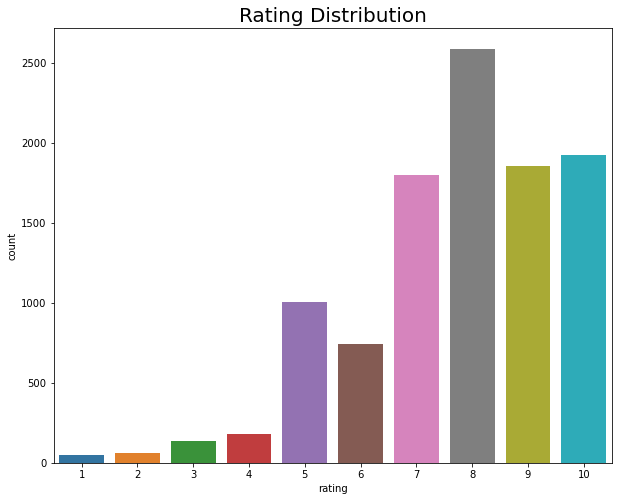

In [38]:
df_rat=df_xtrct[['rating']].copy()
df_rat.dtypes
df_rat = df_rat[df_rat['rating'] != 0]
plt.figure(figsize=(10,8))
sns.countplot(x='rating',data=df_rat)
plt.title('Rating Distribution',size=20)
plt.show()

Taking into consideration all results shown above, our model can be considered effective and highly accurate.